# Predicting BitCoin Volume

## Goals:

- Investigate drivers of volume in BitCoin Market Data from January 2018 to December 2022.

- Construct a ML time-series model that accurately predicts volume of Bitcoin.

# Import

In [1]:
import warnings
warnings.filterwarnings("ignore")


import requests

import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit 


import wrangle as w
import explore as e
import model as m

# Acquire

- Data acquired from messari.io


- It contained 1768 rows and 5 columns before cleaning


- Each row represents one day from 01/01/2018 to 12/12/2022


- Each column represents a feature that describes BitCoin

In [2]:
# Acquiring and cleaning data
btc = w.get_crypto_price('btc', '2018-01-01', '2022-12-12')

btc = w.clean_data(btc)

In [3]:
btc.head(3)

,btc_open,btc_high,btc_low,btc_close,btc_volume
date,,,,,
2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.915844
2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111
2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639


# Prepare


- Checked for missing dates and nulls, filled 40 missing dates with data from the nearest data.


- Extended the length of data from 12-12-2022 to 12-31-2022, then filled data with nearest dates for modeling purposes.


- Renamed columns for readability


- Split data into train, validate, and test sets


- All observations were significant, none were removed


- We have 1825 rows after cleaning and filling.

In [4]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2018-01-01 to 2022-12-31
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   btc_open    1825 non-null   float64
 1   btc_high    1825 non-null   float64
 2   btc_low     1825 non-null   float64
 3   btc_close   1825 non-null   float64
 4   btc_volume  1825 non-null   float64
dtypes: float64(5)
memory usage: 85.5 KB


# Data Dictionary

| Feature | Definition |
| :- | :- |
| btc_open | Decimal value, opening price of BitCoin for the day. |
| btc_close | Decimal value, closing price of BitCoin for the day. |
| btc_high | Decimal value, highest price of BitCoin for the day. |
| btc_low | Decimal value, lowest price of BitCoin for the day. |
| btc_volume | Decimal value, number of shares traded in BitCoin for the day. |

In [5]:
# split into train, validate, test by year
train = btc[:'2020']
validate = btc['2021']
test = btc['2022']

# Explore


- Only exploring the train data.

## Questions:

- Does volume have seasonality over time?


- Do opening price and volume have a relationship?


- Do closing price and volume have a relationship?


- Do highest price and volume have a relationship?


- Do lowest price and volume have a relationship?

## Looking into seasonality..

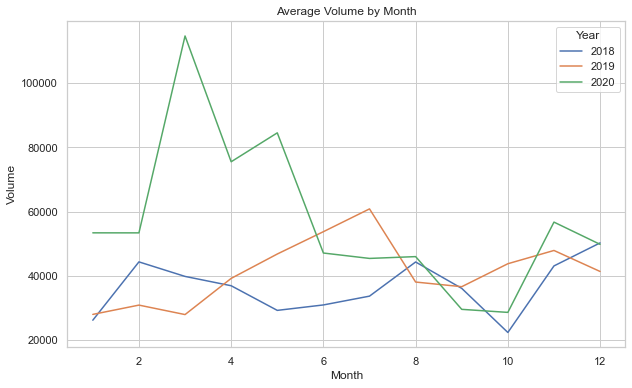

In [6]:
# get plot of Average Volume of BitCoin per month
e.get_avg_vol_monthly()

- Monthly averages seem to share very weak seasonality that only appears around September-November.

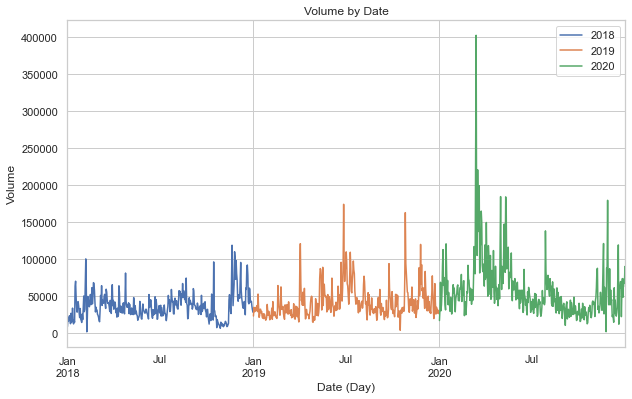

In [7]:
# get plot of Volume for each day
e.get_vol_by_date()

- Daily values appear to share little to no seasonality over the span of 3 years.

## Do open, close, highest or lowest price share a relationship with volume?

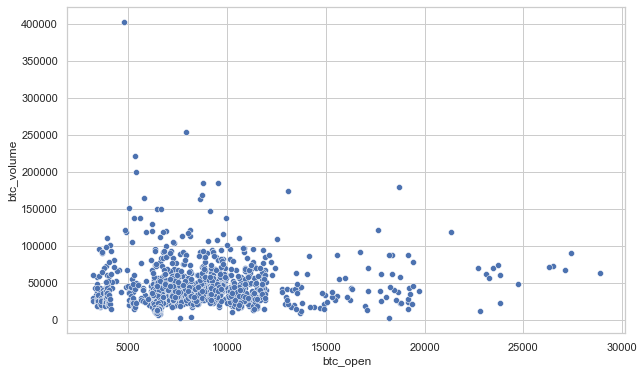

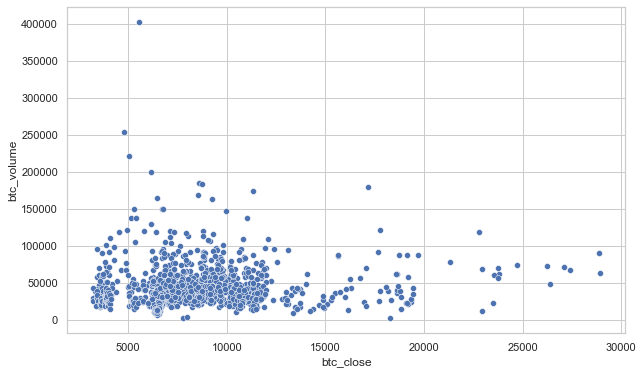

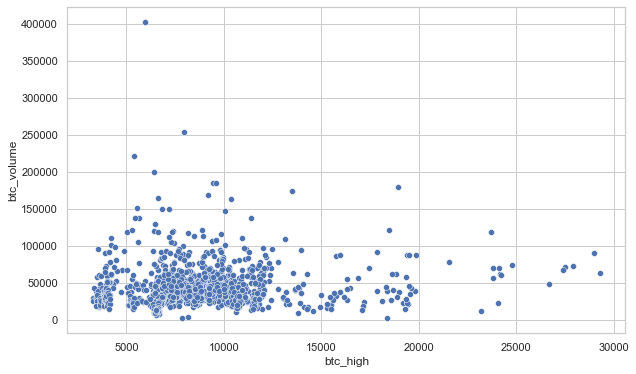

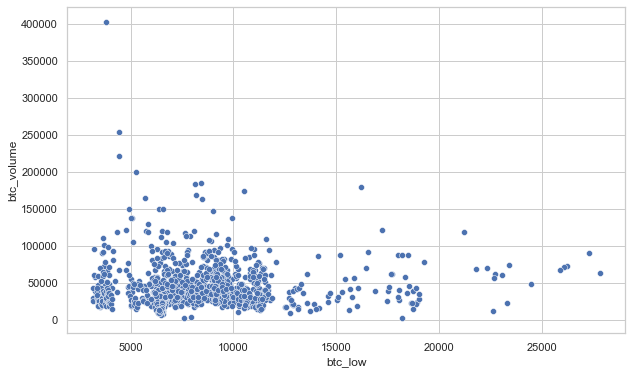

In [8]:
# get plots of volume over price
e.plot_price_vol()

- There appears to be no significant relationship between open, close, highest, or lowest price and volume.

## Exploration Summary

- There were no significant relationships between volume and the rest of the features in our train data.


- We move on to modeling our target variable.

# Modeling

- RMSE is the metric to compare models against each other.


- Models are fit on train data, then predict on validate data.


- Model with the lowest RMSE will be considered the strongest and move on to test data.

In [9]:
# function for updating an evaluation dataframe for comparison purposes
def update_eval_df(model_type, eval_df, col, validate, yhat_df):
    rmse = m.evaluate(col, validate, yhat_df)
    d = {'model_type': [model_type], 'target_var': [col], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    eval_df=eval_df.append(d, ignore_index = True)
    
    return eval_df

In [10]:
# Create the empty dataframe for evaluation
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# Initialize volume, yhat_df, and period for modeling
volume = 0

yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                       index = validate.index)

period = 0

# setting btc_volume to variable to use in function arguments
col = 'btc_volume'

## Last Observed (our Baseline)

In [11]:
# get Last Observed rmse and update eval_df
volume, yhat_df = m.get_btc_last_observed(train, validate, volume, yhat_df)

eval_df = update_eval_df('last_observed', eval_df, col, validate, yhat_df)

btc_volume -- RMSE: 36067


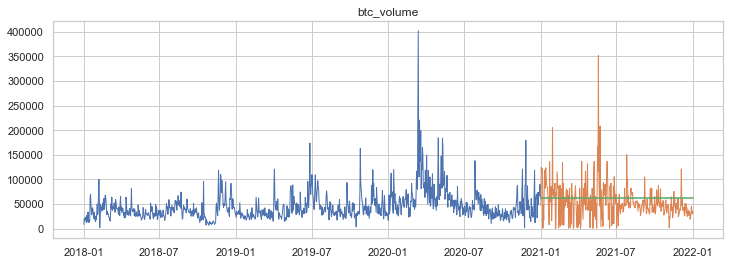

In [12]:
m.plot_and_eval(col, train, validate, yhat_df)

## Simple Average

In [13]:
# get Simple Average rmse and update eval_df
volume, yhat_df = m.get_btc_simple_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('simple_average', eval_df, col, validate, yhat_df)

btc_volume -- RMSE: 36780


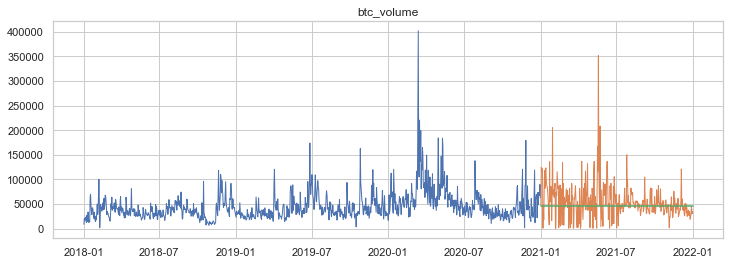

In [14]:
m.plot_and_eval(col, train, validate, yhat_df)

- Slightly worse than baseline.

# Moving Average

### 30 Day Period

In [15]:
# get 30 Day Period rmse and update eval_df
volume, yhat_df = m.get_btc_30d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('30d_moving_average', eval_df, col, validate, yhat_df)

btc_volume -- RMSE: 35674


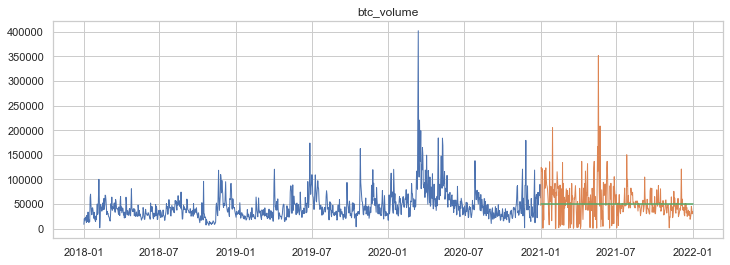

In [16]:
m.plot_and_eval(col, train, validate, yhat_df)

- Slightly better than baseline.

### 7 Day Period

In [17]:
# get 7 Day Period rmse and update eval_df
volume, yhat_df = m.get_btc_7d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('7d_moving_average', eval_df, col, validate, yhat_df)

btc_volume -- RMSE: 38030


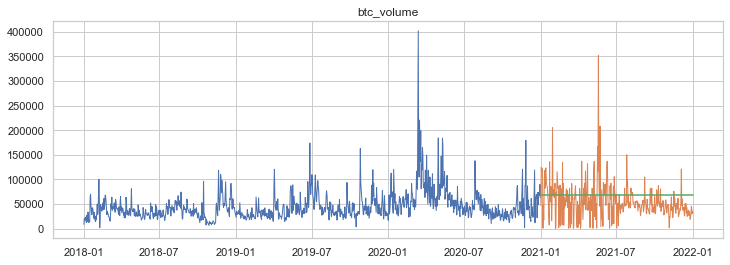

In [18]:
m.plot_and_eval(col, train, validate, yhat_df)

- Worse than baseline.

### 14 Day Period

In [19]:
# get 14 Day Period rmse and update eval_df
volume, yhat_df = m.get_btc_14d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('14d_moving_average', eval_df, col, validate, yhat_df)

btc_volume -- RMSE: 35616


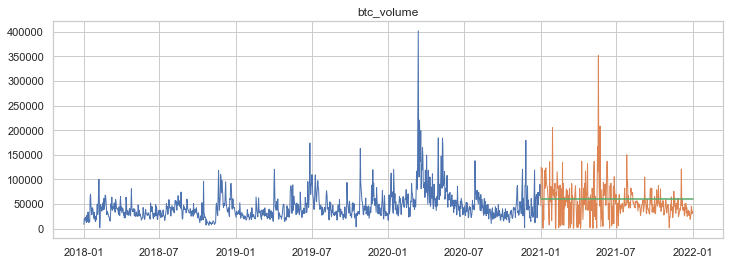

In [20]:
m.plot_and_eval(col, train, validate, yhat_df)

- Slightly better than baseline.

### 21 Day Period

In [21]:
# get 21 Day Period rmse and update eval_df
volume, yhat_df = m.get_btc_21d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('21d_moving_average', eval_df, col, validate, yhat_df)

btc_volume -- RMSE: 35361


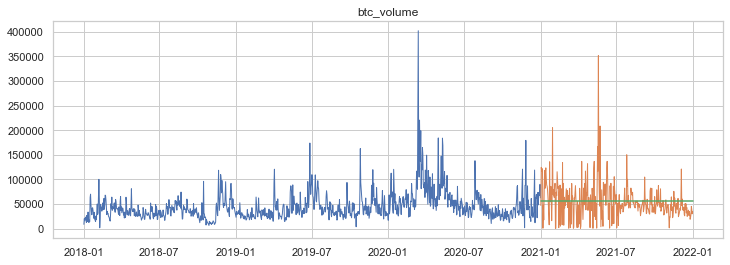

In [22]:
m.plot_and_eval(col, train, validate, yhat_df)

- Slightly better than baseline.

### 28 Day Period

In [23]:
# get 28 Day Period rmse and update eval_df
volume, yhat_df = m.get_btc_28d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('28d_moving_average', eval_df, col, validate, yhat_df)

btc_volume -- RMSE: 35676


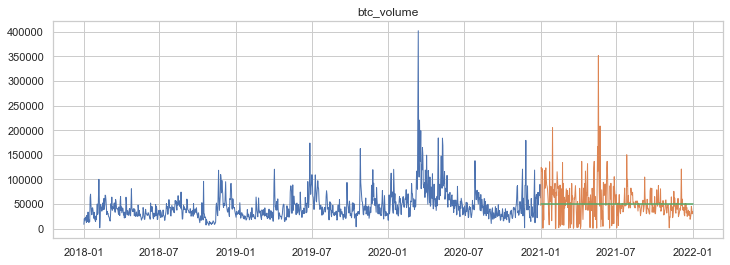

In [24]:
m.plot_and_eval(col, train, validate, yhat_df)

- Slightly better than baseline.

### 120 Day Period

In [25]:
# get 120 Day Period rmse and update eval_df
volume, yhat_df = m.get_btc_120d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('120d_moving_average', eval_df, col, validate, yhat_df)

btc_volume -- RMSE: 37989


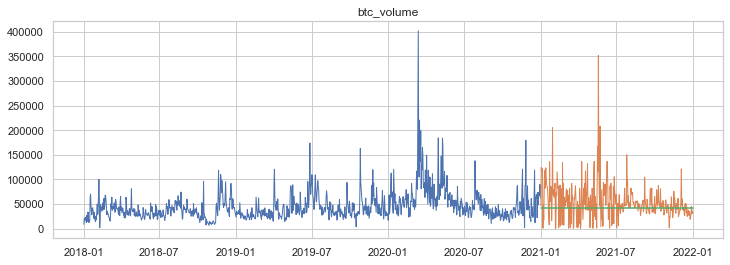

In [26]:
m.plot_and_eval(col, train, validate, yhat_df)

- Worse than baseline.

# Previous Cycle

In [27]:
# get Previous Cycle rmse and update eval_df
yhat_df = m.get_btc_previous_cycle(train, validate)

eval_df = update_eval_df('previous_cycle', eval_df, col, validate, yhat_df)

btc_volume -- RMSE: 54671


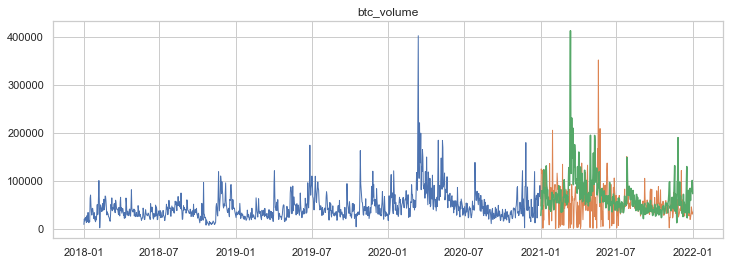

In [28]:
m.plot_and_eval(col, train, validate, yhat_df)

- Significantly worse than baseline.

## Comparing Models

In [29]:
# show evaluation dataframe
eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,7d_moving_average,btc_volume,38030.0
4,14d_moving_average,btc_volume,35616.0
5,21d_moving_average,btc_volume,35361.0
6,28d_moving_average,btc_volume,35676.0
7,120d_moving_average,btc_volume,37989.0
8,previous_cycle,btc_volume,54671.0


- Comparing the RMSE's, 21d_moving_average performed the best on validate data with RMSE == 35361.0. It will be used on test data.

# Model on Test

In [30]:
# using 21d_moving_average on test and updating eval_df
volume, yhat_df = m.get_test_btc_21d_average(train, test, volume, yhat_df)

eval_df = update_eval_df('test_21d_moving_average', eval_df, col, test, yhat_df)

btc_volume -- RMSE: 68477


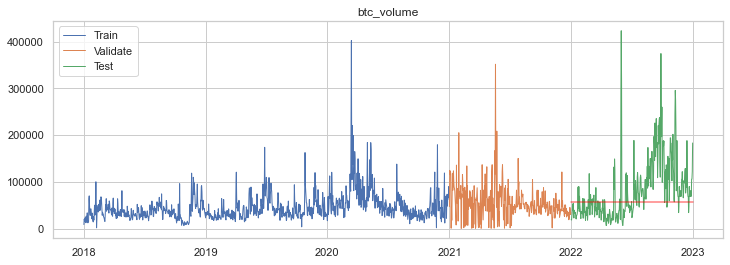

In [31]:
m.plot_and_eval_test(col, train, validate, test, yhat_df)

- 21d_moving_average performed significantly worse on the test data compared to validate data

In [32]:
eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,7d_moving_average,btc_volume,38030.0
4,14d_moving_average,btc_volume,35616.0
5,21d_moving_average,btc_volume,35361.0
6,28d_moving_average,btc_volume,35676.0
7,120d_moving_average,btc_volume,37989.0
8,previous_cycle,btc_volume,54671.0
9,test_21d_moving_average,btc_volume,68477.0


## Modeling Summary


- Overall, models using the average over a period of time performed similarly to baseline.


- 21d_moving_average performed best, but performed significantly worse on the test data.

# Conclusions

### Exploration


- Price seems to not share a relationship with volume.


- Volume seems to not have seasonality.

### Modeling


#### The best model on validate data performed significantly worse on test data.


#### Possible reasons for this:

- Volume lacks seasonality and the data from 2022 is significantly different than 2018-2021

### Using the model is worse than no model at all.

## Recommendations


- Approach the project differently with more sophisticated data, exploration, and models to use.

## Next Steps


- Acquire data from another api that gives more frequent intervals of data in a day.


- Learn more sophisticated modeling with regards to stock market 